In [8]:
# Code to import standard libraries

import sys
sys.path.append("../lib") # go to parent dir

import numpy as np
import scipy
import pandas as pd

import income.distributions as distributions
import income.utils as utils
import income.surveys as surveys

%matplotlib inline
from IPython.display import HTML

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,4)
colors = ['r','g','b']

# Canonical representation of distributions

The objective of this project is to display, and allow the user to manipulate, various transformations and statistics of income distributions, for example:

1. Showing any of the p.d.f, the c.d.f, or the Lorenz curve, etc
2. Calculating Gini coefficient, extreme poverty incidence, etc
3. Combining distributions (e.g. for all EU countries)

In order to permit this, we required a standard representation of an income distribution which is compact in size (since hundreds of these must be downloaded to initialize the app) and which permits fast transformation such as the above (since we cannot possibly pre-calculate all the possible combinations).

This motivates our definition of a 'canonical' representation of an income distribution, based on simple linear splines with an optimized set of knots.

## Rejected representations

Several obvious representations were rejected - we briefly outline the reasons here:

1. **Common parametric forms.** These have the advantage of being extremely space efficient (e.g. two real numbers to parameterize a lognormal distribution) and relatively computationally efficient (since for common parametric forms, transformations are mostly available analytically, and are composed of standard function). However, as noted above, we consider these two constraining, imposing strong assumptions on the shape of the distribution.

2. **Lorenz curve spline as estimated.** The end result of the fitting process described in the previous chapter is essentially a fourth order spline with knots at the original income groups, resulting in a representation of at most several hundred real numbers for a given income distribution. However, calculating the points of the density function requires numerical inversion and differentiation, which are both relatively slow iterative processes, so we reject this option.

3. **Gridded, precomputed functions** We could precompute the Lorenz curve, c.d.f and p.d.f over a grid of values (say, 1000, to achieve a smooth appearance), and use this as our representation. This would, of course, be fast, but then each distribution representation would require ~3000 real numbers, or around 12 KB per distribution. As there are around 1400 surveys represented in PovCalNet, this would result in an initial download of 16MB. While not prohibitive, this is still quite large on, e.g. mobile devices.

## Adaptive linear spline representation

The canonical respresentation we adopted was based on a spline representation of the density function, with a fixed number of knots chosen automatically by algorithm to minimise the error. The steps are as follows:

1. Using numerical transformations of the estimated Lorenz curve, generate a dense uniform grid of points of the density, on the interval $[0, Q(p_{max})]$ (we use $p_{max} = 0.99$ presently).

2. Fit a new smoothed spline, of order 1, to this grid of points, varing the smoothing parameter until the resultant spline has around 100 knots. These knots, $\{ y_k, f(y_k) \}$ represent the distribution. (The number 100 is somewhat arbitrary, but was adequate to produce visually smooth curves in all the cases we examined.)

Although a higher-order spline would improve precision of the representation, there are advantages to representing the p.d.f in this piecewise linear function - in particular, it allows efficient calculation of the c.d.f, quantile function and Lorenz curve. Moreover, using (for example) a quadratic (order 2) spline representation would double the size of the representation from 100 to 200 points. Although we haven't tested it, we presume the representation error of a 200 point adaptive linear spline is less than a 100 point quadratic spline.

Below, we show an example of a ~100 point adaptive linear spline fit to an artificially complex mixture distribution. The blue line is the true density, while the red dots are the points selected to represent the density with linear segments. As it demonstrates, even a small number of points produces an adequate fit, because the points are placed in areas of greatest deviation from linearity.

99 knots


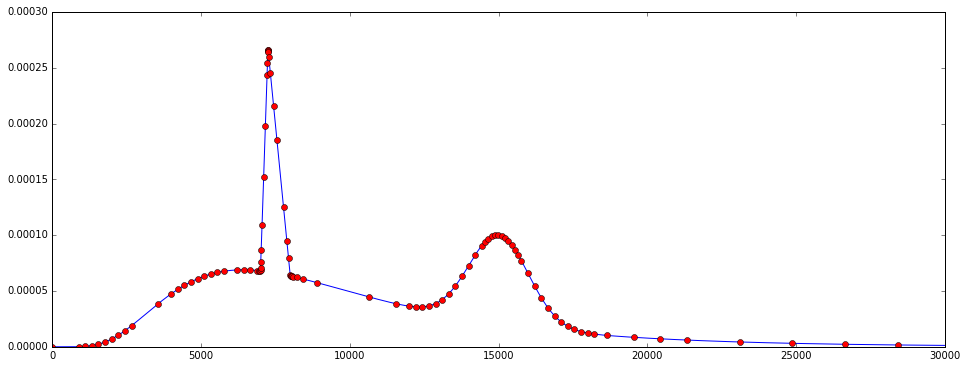

In [71]:
# Code to demonstrate adaptive linear spline fit of a complex mixture distribution

##########################################
plt.rcParams["figure.figsize"] = (16,6)
##########################################

# Generate distribution
dist = utils.MixtureDistribution([
    (0.7, distributions.LognormalIncomeDistribution(mean = 10000, Gini=0.3).dist),
    (0.2, distributions.NormalIncomeDistribution(mean = 15000, stdev = 1000).dist),
    (0.1, distributions.TriangleIncomeDistribution(minimum = 7000, maximum=8000, mode=7250).dist),
])

y = np.linspace(0, 30000, 1000)
plt.plot(y, dist.pdf(y))

# Fit adaptive linear spline
dense_y = np.linspace(0, dist.ppf(0.99), 10000)
spline = scipy.interpolate.UnivariateSpline(dense_y, dist.pdf(dense_y), k=1, s=1e-11)
knots_y = spline.get_knots()
knots_fy = dist.pdf(knots_y)
print("{} knots".format(len(knots_y)))

plt.plot(knots_y, knots_fy, 'ro');

## Transformations

With a density represented by ${y_k, f_k}$ for $k = 1\ldots100$, we can compute points on the major curves efficiently. In the app, these are implemented on the client (browser) side in Javascript.

### Density

Simple linear interpolation. For $y$ with $y_m <= y < y_{m+1}$,
$$
    f(y) = f_m + \frac{y - y_m}{y_{m+1} - y_m} \cdot (f_{m+1} - f_m)
$$

We can reconstruct the density curve from above using the 100 point representation. It is plotted below as red dots. As can be seen, the error compared with the true density (blue dashes) is unnoticeable.

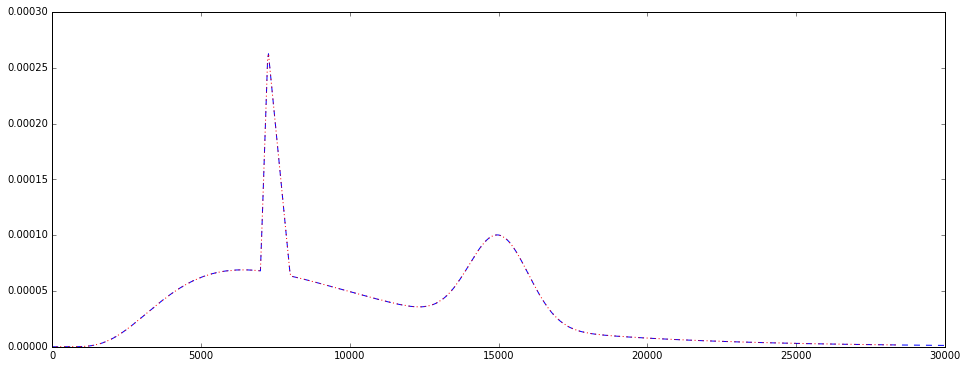

In [60]:
# Code to demonstrate computation of density from canonical representation

##########################################
plt.rcParams["figure.figsize"] = (16,6)
##########################################

def f_scalar(y):
    for i in range(len(knots_y)-1):
        if y < knots_y[i+1]:
            return knots_fy[i] + (y - knots_y[i])/(knots_y[i+1] - knots_y[i]) * (knots_fy[i+1] - knots_fy[i])
f = np.vectorize(f_scalar)
        
plt.plot(y, dist.pdf(y), "b--")
plt.plot(y, f(y), "r:");

### Distribution

Integration to quadratic, then cumulation. For $y$ with $y_m <= y < y_{m+1}$,
$$
    F(y) = \left( \Sigma_{k = 0}^m \int_{y_k}^{y_{k+1}} f_k + \frac{t - y_k}{y_{k+1} - y_k} \cdot (f_{k+1} - f_k)\, dt \right) + \left( \int_{y_m}^y f_m + \frac{t - y_m}{y_{m+1} - y_m} \cdot (f_{m+1} - f_m)\, dt \right)
$$
which can be solved straightforwardly. The partial sums of the first term are pre-computed on first load for all ${k}$ to improve speed.

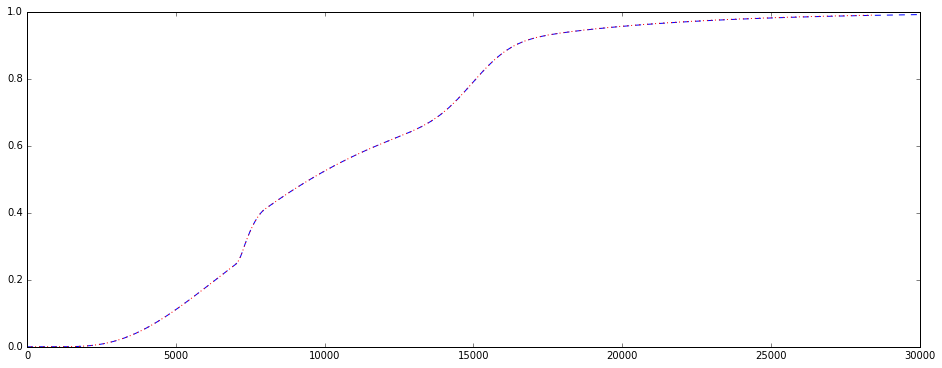

In [74]:
# Code to demonstrate computation of the c.d.f. from canonical representation

##########################################
plt.rcParams["figure.figsize"] = (16,6)
##########################################

# Precompute the partial sums
knots_Fy = np.hstack(([0],np.cumsum((knots_fy[1:] + knots_fy[:-1])/2 * (knots_y[1:] - knots_y[:-1]))))

def F_scalar(y):
    for i in range(len(knots_y)-1):
        if y < knots_y[i+1]:
            return knots_Fy[i] + (y - knots_y[i]) * knots_fy[i] + (1/2) * (knots_fy[i+1] - knots_fy[i]) / (knots_y[i+1] - knots_y[i]) * (y - knots_y[i])**2
F = np.vectorize(F_scalar)
        
plt.plot(y, dist.cdf(y), "b--")
plt.plot(y, F(y), "r:");

### Quantile function and Lorenz curve

The quantile function uses the same precomputed array of c.d.f values, doing a reverse lookup to find the relevant segment. Then, the distribution function is inverted analytically to produce the precise value.

The Lorenz curve can then be computed by analytically integrating the quantile curve. Since it is normalised by the mean, that too must be computed numerically (done once at load time).

### Other statistics

Most other statistics that we present are easily calculated from one of the above functions: that includes median, extreme poverty headcount, Gini index, histograms.

## Aggregations and interpolations

Two types of aggregations are used in the app, and we take a different approach to each:

1. For aggregating two distributions (e.g combining urban plus rural to get a national distribution, or interpolating between two years), we take the union of both sets of ${y_k}$, then generate new p.d.f points by a simple weighted linear combination - resulting in an new aggregate representation with ~200 points.

2. For aggregating many distributions (e.g. to generated the aggregate distribution for a region or other set of countries) we generate a new uniform grid with 1000 points, since the above approach would result in too many points. It's possible the above method could be adapted by first thinning the aggregate distribution back to 100 points before adding each subsequent distribution, but we haven't investigated this.

In either case, transformations of the aggregate distribution now follow as above.